In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from tabulate import tabulate

In [21]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)


In [23]:
# View all of the classes that automap found
reflected_classes = Base.classes.keys()
for class_name in reflected_classes:
    print(class_name)

measurement
station


In [24]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [26]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date[0]

print("The most recent date in the dataset is:", most_recent_date)

The most recent date in the dataset is: 2017-08-23


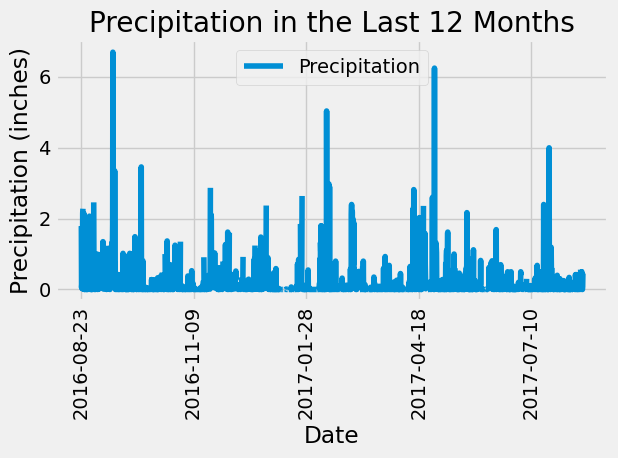

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = last_date[0]
one_year_ago = (pd.to_datetime(last_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])


# Sort the dataframe by date
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='Precipitation', rot=90)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation in the Last 12 Months")
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()

In [28]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['Precipitation'].describe()
title = "Precipitation"
table = tabulate(summary_stats.to_frame(), headers=[title], tablefmt="fancy_grid")
print(table)

╒═══════╤═════════════════╕
│       │   Precipitation │
╞═══════╪═════════════════╡
│ count │     2021        │
├───────┼─────────────────┤
│ mean  │        0.177279 │
├───────┼─────────────────┤
│ std   │        0.46119  │
├───────┼─────────────────┤
│ min   │        0        │
├───────┼─────────────────┤
│ 25%   │        0        │
├───────┼─────────────────┤
│ 50%   │        0.02     │
├───────┼─────────────────┤
│ 75%   │        0.13     │
├───────┼─────────────────┤
│ max   │        6.7      │
╘═══════╧═════════════════╛


# Exploratory Station Analysis

In [29]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [31]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

print("Most Active Stations:")
print("---------------------")
for station, count in station_counts:
    print(f"Station: {station}, Count: {count}")

Most Active Stations:
---------------------
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_counts[0][0]

temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

# Extract the results
lowest_temp = temperature_stats[0][0]
highest_temp = temperature_stats[0][1]
avg_temp = temperature_stats[0][2]

print(f"Temperature Statistics for Station {most_active_station}:")
print("--------------------------------------------")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")

Temperature Statistics for Station USC00519281:
--------------------------------------------
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


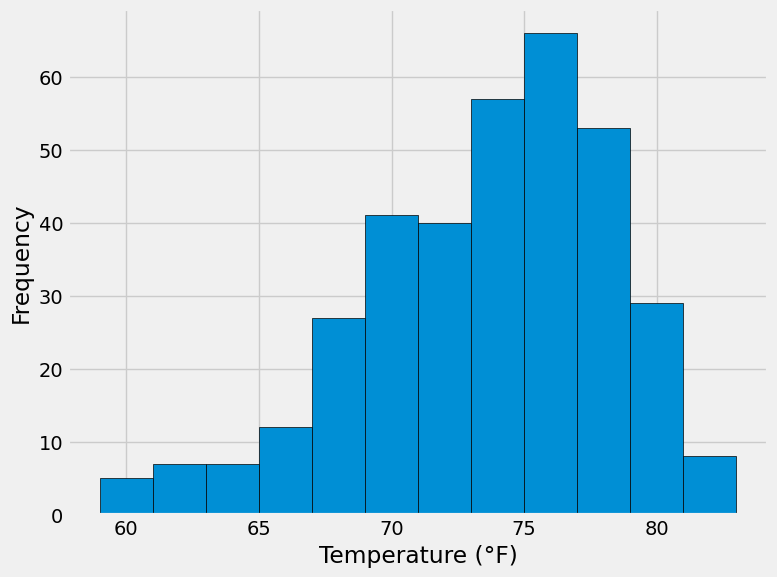

In [34]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

temperatures = [result[0] for result in temperature_data]

plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()